In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os

ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

In [2]:
#Shapefiles used for extracting pixel values - all within the GCE domain

gce_clip = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_simple.shp' ##Simplified GCE domain - reduced number of vertices
vcr_clip = 'F:/Wetlands shapefiles/VA_shapefile_wetlands/VA_simple.shp' ##Simplified VCR domain - reduced number of vertices
pie_clip = 'F:/Wetlands shapefiles/MA_shapefile_wetlands/MA_simple.shp' ##Simplified PIE domain - reduced number of vertices
wet_ga = geemap.shp_to_ee(gce_clip)
wet_va = geemap.shp_to_ee(vcr_clip)
wet_ma = geemap.shp_to_ee(pie_clip)
joinedFeatures = wet_ga.union()

gce_clipdiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_simpledissolve.shp'
dissolve_ga = geemap.shp_to_ee(gce_clipdiss)

gce_smalldiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_smalldissolve.shp'
gce_smalldiss2 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_smalldissolve2.shp'
gce_smalldiss3 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_smalldissolve3.shp'

smalldissolve_ga = geemap.shp_to_ee(gce_smalldiss)
small2dissolve_ga = geemap.shp_to_ee(gce_smalldiss2)
small3dissolve_ga = geemap.shp_to_ee(gce_smalldiss3)


#Note 1/18/23: Flux tower footprint (fluxproper) OR expanded flux area (fluxdiss)
gce_fluxdiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_fluxdissolve.shp'

gce_fluxproper = 'F:/Wetlands shapefiles/GCE flux tower/sapelo_yearly_climatology-2019.shp'

flux_ga = geemap.shp_to_ee(gce_fluxproper)

In [3]:
#Pixel counts of each region:
image = ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_016038_19990711')
x = image.reduceRegion(geometry=flux_ga, reducer=ee.Reducer.count(), scale=30)
x.getInfo()

{'QA_PIXEL': 71,
 'QA_RADSAT': 71,
 'SR_ATMOS_OPACITY': 71,
 'SR_B1': 71,
 'SR_B2': 71,
 'SR_B3': 71,
 'SR_B4': 71,
 'SR_B5': 71,
 'SR_B7': 71,
 'SR_CLOUD_QA': 71,
 'ST_ATRAN': 71,
 'ST_B6': 71,
 'ST_CDIST': 71,
 'ST_DRAD': 71,
 'ST_EMIS': 71,
 'ST_EMSD': 71,
 'ST_QA': 71,
 'ST_TRAD': 71,
 'ST_URAD': 71}

In [4]:
##FLATS

#12/08/22 - add calibrated flats to images
def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

# def addFLATSL9(image):
#     flats = ee.Image(0).expression(
#         '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
#             'SWIR': image.select('SR_B6'),
#             'NIR': image.select('SR_B5'),
#             'RED': image.select('SR_B4'),
#             'BLUE': image.select('SR_B2')
#         })
    
#     return image.addBands(flats.rename('flats'))


##NOTE: above is 7-9 calibration; below is 8-9 calibration

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.945*(RED-SWIR)/(RED+SWIR) - 0.055) - 41.2*(0.974* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.0005)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

# def addFLATS(image):
#     flats = ee.Image(0).expression(
#         '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
#             'SWIR': image.select('SR_B6'),
#             'RED': image.select('SR_B4'),
#             'GREEN': image.select('SR_B3')
#         })
    
#     return image.addBands(flats.rename('flats'))

# def addFLATSL5(image):
#     flats = ee.Image(0).expression(
#         '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
#             'SWIR': image.select('SR_B5'),
#             'RED': image.select('SR_B3'),
#             'GREEN': image.select('SR_B2')
#         })
    
#     return image.addBands(flats.rename('flats'))

#NDWI
def addndwi(image):
    ndwi = ee.Image(0).expression(
        '((RED-SWIR)/(RED+SWIR))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(ndwi.rename('ndwi'))

def addndwiL5(image):
    ndwi = ee.Image(0).expression(
        '((RED-SWIR)/(RED+SWIR))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(ndwi.rename('ndwi'))

#PHENO
def addpheno(image):
    pheno = ee.Image(0).expression(
        '((GREEN-RED)/(RED+GREEN))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(pheno.rename('pheno'))

def addphenoL5(image):
    pheno = ee.Image(0).expression(
        '((GREEN-RED)/(RED+GREEN))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(pheno.rename('pheno'))

#NIRv
def addnirv(image):
    nirv = ee.Image(0).expression(
        'NIR*(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5')
        })
    
    return image.addBands(nirv.rename('nirv'))

def addnirvL5(image):
    nirv = ee.Image(0).expression(
        'NIR*(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B3'),
            'NIR': image.select('SR_B4')
        })
    
    return image.addBands(nirv.rename('nirv'))

#EVI
def addeviL5(image):
    evi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)', {
            'RED': image.select('SR_B3'),
            'NIR': image.select('SR_B4'),
            'BLUE': image.select('SR_B1'),

        })
    
    return image.addBands(evi.rename('evi'))

def addevi(image):
    evi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5'),
            'BLUE': image.select('SR_B2'),

        })
    
    return image.addBands(evi.rename('evi'))

#12/01/22
#VARI
def addvariL5(image):
    vari = ee.Image(0).expression(
        '(GREEN-RED)/(GREEN+RED-BLUE)', {
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2'),
            'BLUE': image.select('SR_B1'),

        })
    
    return image.addBands(vari.rename('vari'))

def addvari(image):
    vari = ee.Image(0).expression(
        '(GREEN-RED)/(GREEN+RED-BLUE)', {
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3'),
            'BLUE': image.select('SR_B2'),

        })
    
    return image.addBands(vari.rename('vari'))


#GLI
def addgliL5(image):
    gli = ee.Image(0).expression(
        '((GREEN-RED) + (GREEN-BLUE))/(2*GREEN+RED+BLUE)', {
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2'),
            'BLUE': image.select('SR_B1'),

        })
    
    return image.addBands(gli.rename('gli'))

def addgli(image):
    gli = ee.Image(0).expression(
        '((GREEN-RED) + (GREEN-BLUE))/(2*GREEN+RED+BLUE)', {
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3'),
            'BLUE': image.select('SR_B2'),

        })
    
    return image.addBands(gli.rename('gli'))

In [5]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

In [6]:
#Data load
# df1 = pd.read_csv('C:/Users/arj26323/Documents/Data/flats/flats_pairs.csv')
df1 = pd.read_csv('C:/Users/arj26323/Documents/Data/flats/flats_pairdates.csv')
df1['Date_A'] = pd.to_datetime(df1['Date_A'], format = '%Y-%m-%d')
df1['Date_B'] = pd.to_datetime(df1['Date_B'], format = '%Y-%m-%d')

#Tides
tides = pd.read_csv('C:/Users/arj26323/Documents/Data/flats/water_level_filtered_1999_2022.csv')
tides['Date'] = pd.to_datetime(tides['Date'], format = '%m/%d/%Y')

tides['Verified_m'] = tides['Verified_m'].str.replace("\U00002013", "-").str.replace(r'^-$', '0', regex=True).astype(float)

# display(tides['Date'])

dictide = tides.groupby(['Date'], as_index = False).aggregate({'Verified_m': np.mean}).set_index('Date').to_dict()['Verified_m'] 

# df1['Tide_height'] = df1['Date'].map(dictide)

df1['Tide_A'] = df1['Date_A'].map(dictide).astype(float)
df1['Tide_B'] = df1['Date_B'].map(dictide).astype(float)

df1 = df1[df1['Tide_A'].notna() & df1['Tide_B'].notna()]
df1['Tide_diff'] = abs(df1['Tide_B'] - df1['Tide_A']) ##NOTE 1/12/2023: Changed to absolute value 

conditions_A = [ df1['Tide_A'] >= 0.9, (df1['Tide_A'] < 0.9) & (df1['Tide_A']> -1.1), df1['Tide_A'] <= -1.1 ]
conditions_B = [ df1['Tide_B'] >= 0.9, (df1['Tide_B'] < 0.9) & (df1['Tide_B']> -1.1), df1['Tide_B'] <= -1.1 ]
choices = [ "Flood", 'Mid', 'Ebb' ]

df1['Tidestatus_A'] = np.select(conditions_A, choices, default=np.nan)
df1['Tidestatus_B'] = np.select(conditions_B, choices, default=np.nan)

df1

,Unnamed: 0,Image_x,Sensor_x,LS_x,Date_x,Date_A,Image_y,Sensor_y,LS_y,Date_y,Date_B,Tide_A,Tide_B,Tide_diff,Tidestatus_A,Tidestatus_B
0,0,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990711,Landsat 5/7,Landsat 5,1999-07-11,1999-07-11,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990710,Landsat 7/5,Landsat 7,1999-07-10,1999-07-10,-1.453000,-1.697333,0.244333,Ebb,Ebb
1,1,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990727,Landsat 5/7,Landsat 5,1999-07-27,1999-07-27,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990726,Landsat 7/5,Landsat 7,1999-07-26,1999-07-26,-0.645000,-0.911667,0.266667,Mid,Mid
2,2,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990812,Landsat 5/7,Landsat 5,1999-08-12,1999-08-12,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990811,Landsat 7/5,Landsat 7,1999-08-11,1999-08-11,0.426667,-0.031667,0.458333,Mid,Mid
3,3,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990828,Landsat 5/7,Landsat 5,1999-08-28,1999-08-28,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990827,Landsat 7/5,Landsat 7,1999-08-27,1999-08-27,0.575667,0.017000,0.558667,Mid,Mid
4,4,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990913,Landsat 5/7,Landsat 5,1999-09-13,1999-09-13,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990912,Landsat 7/5,Landsat 7,1999-09-12,1999-09-12,1.164667,1.143667,0.021000,Flood,Flood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,48,LANDSAT/LC08/C02/T1_L2/LC08_017038_20220903,Landsat 8/9,Landsat 8,2022-09-03,2022-09-03,LANDSAT/LC09/C02/T1_L2/LC09_016039_20220904,Landsat 9/8,Landsat 9,2022-09-04,2022-09-04,0.752667,0.243667,0.509000,Mid,Mid
634,49,LANDSAT/LC08/C02/T1_L2/LC08_016038_20220912,Landsat 8/9,Landsat 8,2022-09-12,2022-09-12,LANDSAT/LC09/C02/T1_L2/LC09_017038_20220911,Landsat 9/8,Landsat 9,2022-09-11,2022-09-11,0.965333,0.621333,0.344000,Flood,Mid
635,50,LANDSAT/LC08/C02/T1_L2/LC08_016039_20220912,Landsat 8/9,Landsat 8,2022-09-12,2022-09-12,LANDSAT/LC09/C02/T1_L2/LC09_017038_20220911,Landsat 9/8,Landsat 9,2022-09-11,2022-09-11,0.965333,0.621333,0.344000,Flood,Mid
636,51,LANDSAT/LC08/C02/T1_L2/LC08_017038_20220919,Landsat 8/9,Landsat 8,2022-09-19,2022-09-19,LANDSAT/LC09/C02/T1_L2/LC09_016039_20220920,Landsat 9/8,Landsat 9,2022-09-20,2022-09-20,0.021333,-0.332667,0.354000,Mid,Mid


In [7]:
#Low tide/high tide determination; for figures. If tide height > 0.9; high tide. If < -1.1, low tide
#Good = not cloudy
#L5
l5_low = df1[(df1['LS_x'] == 'Landsat 5') & (df1['Tide_A'] < -1.1)]
l5_high = df1[(df1['LS_x'] == 'Landsat 5') & (df1['Tide_A'] > 0.9)]

#L7
l7_low = df1[(df1['LS_x'] == 'Landsat 7') & (df1['Tide_A'] < -1.1)]
l7_high = df1[(df1['LS_x'] == 'Landsat 7') & (df1['Tide_A'] > 0.9)]

#L8
l8_low = df1[(df1['LS_y'] == 'Landsat 8') & (df1['Tide_A'] < -1.1)] #Good
l8_high = df1[(df1['LS_y'] == 'Landsat 8') & (df1['Tide_A'] > 0.9)]

#L9
l9_low = df1[(df1['LS_y'] == 'Landsat 9') & (df1['Tide_A'] < -1.1)] #note the LS_y parameter #Good
l9_high = df1[(df1['LS_y'] == 'Landsat 9') & (df1['Tide_A'] > 0.9)] #Good



#Preliminary choices for low/high comparison:

#L5
'''
Low:
LANDSAT/LT05/C02/T1_L2/LT05_016038_20000627
High:
LANDSAT/LT05/C02/T1_L2/LT05_016038_19990929
'''

#L7
'''
Low:
LANDSAT/LE07/C02/T1_L2/LE07_017038_20000626
High:
LANDSAT/LE07/C02/T1_L2/LE07_017038_19990928
'''
#L8
'''
Low:
LANDSAT/LC08/C02/T1_L2/LC08_016038_20211230 #Good

High:
LANDSAT/LC08/C02/T1_L2/LC08_017038_20130724
'''
#L9

'''
Low:
LANDSAT/LC09/C02/T1_L2/LC09_017038_20211229 #Good

High:
LANDSAT/LC09/C02/T1_L2/LC09_017038_20220303 #Good
'''

l8_high
# l5_low

,Unnamed: 0,Image_x,Sensor_x,LS_x,Date_x,Date_A,Image_y,Sensor_y,LS_y,Date_y,Date_B,Tide_A,Tide_B,Tide_diff,Tidestatus_A,Tidestatus_B
333,5,LANDSAT/LE07/C02/T1_L2/LE07_016038_20130725,Landsat 7/8,Landsat 7,2013-07-25,2013-07-25,LANDSAT/LC08/C02/T1_L2/LC08_017038_20130724,Landsat 8/7,Landsat 8,2013-07-24,2013-07-24,1.149333,0.720333,0.429000,Flood,Mid
335,7,LANDSAT/LE07/C02/T1_L2/LE07_016038_20130826,Landsat 7/8,Landsat 7,2013-08-26,2013-08-26,LANDSAT/LC08/C02/T1_L2/LC08_017038_20130825,Landsat 8/7,Landsat 8,2013-08-25,2013-08-25,1.215000,1.400333,0.185333,Flood,Flood
336,8,LANDSAT/LE07/C02/T1_L2/LE07_016038_20130911,Landsat 7/8,Landsat 7,2013-09-11,2013-09-11,LANDSAT/LC08/C02/T1_L2/LC08_017038_20130910,Landsat 8/7,Landsat 8,2013-09-10,2013-09-10,1.067667,1.168333,0.100667,Flood,Flood
341,13,LANDSAT/LE07/C02/T1_L2/LE07_017038_20131105,Landsat 7/8,Landsat 7,2013-11-05,2013-11-05,LANDSAT/LC08/C02/T1_L2/LC08_016039_20131106,Landsat 8/7,Landsat 8,2013-11-06,2013-11-06,1.221667,1.469333,0.247667,Flood,Flood
343,15,LANDSAT/LE07/C02/T1_L2/LE07_017038_20131121,Landsat 7/8,Landsat 7,2013-11-21,2013-11-21,LANDSAT/LC08/C02/T1_L2/LC08_016039_20131122,Landsat 8/7,Landsat 8,2013-11-22,2013-11-22,1.185333,1.077000,0.108333,Flood,Flood
345,17,LANDSAT/LE07/C02/T1_L2/LE07_017038_20131207,Landsat 7/8,Landsat 7,2013-12-07,2013-12-07,LANDSAT/LC08/C02/T1_L2/LC08_016039_20131208,Landsat 8/7,Landsat 8,2013-12-08,2013-12-08,1.045333,0.987667,0.057667,Flood,Flood
358,30,LANDSAT/LE07/C02/T1_L2/LE07_017038_20140601,Landsat 7/8,Landsat 7,2014-06-01,2014-06-01,LANDSAT/LC08/C02/T1_L2/LC08_016038_20140602,Landsat 8/7,Landsat 8,2014-06-02,2014-06-02,1.100667,0.947667,0.153000,Flood,Flood
360,32,LANDSAT/LE07/C02/T1_L2/LE07_017038_20140617,Landsat 7/8,Landsat 7,2014-06-17,2014-06-17,LANDSAT/LC08/C02/T1_L2/LC08_016038_20140618,Landsat 8/7,Landsat 8,2014-06-18,2014-06-18,1.123667,0.838000,0.285667,Flood,Mid
366,38,LANDSAT/LE07/C02/T1_L2/LE07_016038_20140813,Landsat 7/8,Landsat 7,2014-08-13,2014-08-13,LANDSAT/LC08/C02/T1_L2/LC08_017038_20140812,Landsat 8/7,Landsat 8,2014-08-12,2014-08-12,1.086333,0.834000,0.252333,Flood,Mid
368,40,LANDSAT/LE07/C02/T1_L2/LE07_016038_20140829,Landsat 7/8,Landsat 7,2014-08-29,2014-08-29,LANDSAT/LC08/C02/T1_L2/LC08_017038_20140828,Landsat 8/7,Landsat 8,2014-08-28,2014-08-28,1.007000,0.970667,0.036333,Flood,Flood


In [8]:
df57 = df1.iloc[:328,:] #Note: this range changed when NaN tide rows were filtered out of df1

def addTide(img):
    tidediff = img.getNumber('tidediff')
    new_value = ee.Image(tidediff).rename('tidedifference')
    return img.addBands(new_value)

def clippy(img):
    return img.clip(flux_ga)

# def addTidestatusA(img):
#     tidestatusA = img.get('tidestatusA')
#     new_value = ee.Image(tidestatusA).rename('tidestatusA')
#     return img.addBands(new_value)

# def addTidestatusB(img):
#     tidestatusB = img.getNumber('tidestatusB')
#     new_value = ee.Image(tidestatusB).rename('tidestatusB')
#     return img.addBands(new_value)

calibr = []
for i in range(len(df57)):
    x = ee.Image(addFLATSL5(addvariL5(addeviL5(addnirvL5(addphenoL5(addndwiL5(maskL5sr(ee.Image(df57.loc[i, 'Image_x'])))))))))
    y = ee.Image(addFLATSL7(addvariL5(addeviL5(addnirvL5(addphenoL5(addndwiL5(maskL5sr(ee.Image(df57.loc[i, 'Image_y'])))))))))
    combined_image = addTide(x.addBands(y).set({'tidediff':df57.loc[i, 'Tide_diff']}))
    try:
        region = flux_ga #flux_ga vs. dissolve_ga
        sample57x = geemap.ee_to_pandas(combined_image.sampleRegions(collection = region, scale = 30))
        calibr.append(sample57x) 
    except Exception:
        try:
            region = flux_ga
            sample57x = geemap.ee_to_pandas(combined_image.sampleRegions(collection = region, scale = 30))
            calibr.append(sample57x)
        except Exception:
            continue

calibr_list = pd.concat(calibr) #239 pairs of dates

17
4


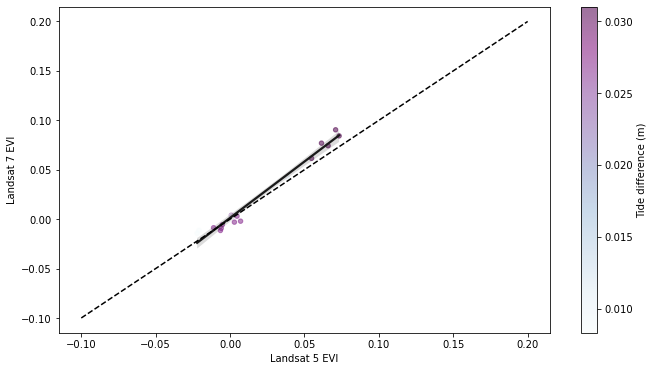

In [9]:
import seaborn as sns

calibr_list = pd.concat(calibr)

# calibr_list = calibr_list[calibr_list['ndwi_1'].between(-2, 2)] #just getting rid of the outliers - pheno and ndwi
# calibr_list = calibr_list[calibr_list['evi_1'].between(-2, 2)] #just getting rid of the outliers
calibr_list = calibr_list[calibr_list['tidedifference'].between(-0.04, 0.04)]

##NOTE: EVI seems very robust to tide differences

# g = sns.FacetGrid(data=calibr_list, aspect=1.5, palette='BuGn', height=5) #change point size to better visualize
# g = sns.lmplot(data=calibr_list, x = 'ndwi', y='ndwi_1', aspect=1.5, palette='BuGn', height=5)
# g.map(plt.scatter, 'ndwi', 'ndwi_1').add_legend()
# g.set_axis_labels("L5 ndwi", "L7 ndwi")

fig, ax = plt.subplots()
fig.set_size_inches(11, 6)

points = plt.scatter(data = calibr_list, x = 'evi', y='evi_1',
                     c="tidedifference", s=20, cmap='BuPu', alpha=0.55)
plt.colorbar(points, label = 'Tide difference (m)')
sns.regplot(x='evi', y="evi_1", data=calibr_list, scatter=False, color=".1").set(xlabel='Landsat 5 EVI', ylabel='Landsat 7 EVI')

plt.plot([-0.1, 0.2], [-0.1, 0.2], 'k--')

print(len(calibr_list))
print(len(calibr_list['tidedifference'].unique()))

# plt.plot([-1, 1.5], [-1, 1.5], 'k--')

# plt.savefig('fluxtowerevi_75.png', bbox_inches='tight', dpi = 300)

In [10]:
#Cross cal regression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score

calibr_list = pd.concat(calibr)
calibr_list = calibr_list[calibr_list['tidedifference'].between(-0.04, 0.04)] #Keep it consistent

#evi
# lm = LinearRegression().fit(np.array(calibr_list.evi_1).reshape((-1, 1)), np.array(calibr_list.evi).reshape((-1, 1)))
print('evi: ')

#L7 = m*L5 + c

y = calibr_list['evi_1'] #L7
x = calibr_list[['evi']] #L5
lm = LinearRegression().fit(x,y)

print(lm.coef_)
print(lm.intercept_)
print(lm.score)
print(len(x))

print(lm.score(x,y))

#ndwi
print('ndwi: ')

calibr_list = calibr_list[calibr_list['tidedifference'].between(-0.02, 0.02)]

y = calibr_list['ndwi_1'] #L7
x = calibr_list[['ndwi']] #L5
lm = LinearRegression().fit(x,y)

print(lm.coef_)
print(lm.intercept_)
print(lm.score)

print(lm.score(x,y))
print(len(x))

evi: 
[1.13958879]
0.0012977455459822415
<bound method RegressorMixin.score of LinearRegression()>
17
0.9762173971798498
ndwi: 
[0.82241062]
-0.06518740017684033
<bound method RegressorMixin.score of LinearRegression()>
0.9242471954736458
4


In [11]:
df78 = df1.iloc[328:581,:] #Again, this range changes when NaN tide rows are filtered out

def addTide(img):
    tidediff = img.getNumber('tidediff')
    new_value = ee.Image(tidediff).rename('tidedifference')
    return img.addBands(new_value)

def clippy(img):
    return img.clip(flux_ga)

calibr2 = []
for i in range(332,585): #Again, this range changes when NaN tide rows are filtered out
    x = ee.Image(addFLATSL7(addvariL5(addeviL5(addnirvL5(addphenoL5(addndwiL5(maskL5sr(ee.Image(df78.loc[i, 'Image_x'])))))))))
    y = ee.Image(addFLATSL8(addvari(addevi(addnirv(addpheno(addndwi(maskL5sr(ee.Image(df78.loc[i, 'Image_y'])))))))))
    combined_image = addTide(x.addBands(y).set({'tidediff':df78.loc[i, 'Tide_diff']}))
    try:
        region = flux_ga
        sample78x = geemap.ee_to_pandas(combined_image.sampleRegions(collection = region, scale = 30))
        calibr2.append(sample78x) 
    except Exception:
        try:
            region = flux_ga
            sample78x = geemap.ee_to_pandas(combined_image.sampleRegions(collection = region, scale = 30))
            calibr2.append(sample78x)
        except Exception:
            continue

calibr_78 = pd.concat(calibr2) #171 unique pairs

597
60


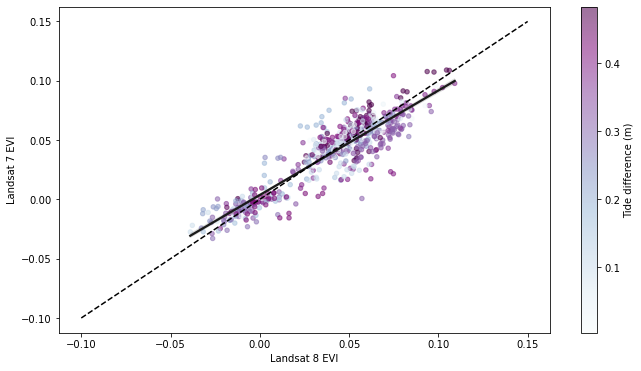

In [12]:
import seaborn as sns

calibr_78 = pd.concat(calibr2)

# calibr_78 = calibr_78[calibr_78['ndwi'].between(-2, 2) & calibr_78['ndwi_1'].between(-2, 2)] #getting rid of the outliers
calibr_78 = calibr_78[calibr_78['evi'].between(-1, 1)] #just getting rid of the outliers
calibr_78 = calibr_78[calibr_78['tidedifference'].between(-0.5, 0.5)]
calibr_78 = calibr_78[calibr_78['tidedifference'] != 0] #removing weird values - recalculate coefficients

fig, ax = plt.subplots()
fig.set_size_inches(11, 6)

points = plt.scatter(data = calibr_78, x = 'evi_1', y='evi',
                     c="tidedifference", s=20, cmap="BuPu", alpha=0.55)
plt.colorbar(points, label = 'Tide difference (m)')
sns.regplot(x='evi_1', y="evi", data=calibr_78, scatter=False, color=".1").set(xlabel='Landsat 8 EVI', ylabel='Landsat 7 EVI')

# plt.plot([-0.25, 0.5], [-0.25, 0.5], 'k--')

# display(calibr_78)
print(len(calibr_78))
print(len(calibr_78['tidedifference'].unique()))
# print(calibr_78['tidedifference'].unique()) ##LOOKING FOR STRANGE PAIR

plt.plot([-0.1, 0.15], [-0.1, 0.15], 'k--')

# plt.savefig('flux_evi_78.png', bbox_inches='tight', dpi = 300)

In [13]:
#Cross cal regression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score

calibr_78 = pd.concat(calibr2)
calibr_78 = calibr_78[calibr_78['tidedifference'] != 0] #removing weird values - recalculate coefficients. One weird pair
calibr_78 = calibr_78[calibr_78['tidedifference'].between(-0.04, 0.04)] #Keep it consistent

#evi

# lm = LinearRegression().fit(np.array(calibr_list.evi_1).reshape((-1, 1)), np.array(calibr_list.evi).reshape((-1, 1)))
print('evi: ')

# calibr_78 = calibr_78[calibr_78['evi'].between(-1, 1)] #just getting rid of the outliers

#L7 = m*L8 + c

x = calibr_78[['evi_1']] #L8
y = calibr_78['evi'] #L7
lm = LinearRegression().fit(x,y)

print(lm.coef_)
print(lm.intercept_)
print(lm.score)
print(len(x))

print(lm.score(x,y))

#ndwi
print('ndwi: ')

calibr_78 = calibr_78[calibr_78['tidedifference'].between(-0.02, 0.02)]

x = calibr_78[['ndwi_1']] #L8
y = calibr_78['ndwi'] #L7
lm = LinearRegression().fit(x,y)

print(lm.coef_)
print(lm.intercept_)
print(lm.score)

print(lm.score(x,y))
print(len(x))

evi: 
[0.78324236]
0.010589604788272942
<bound method RegressorMixin.score of LinearRegression()>
41
0.8152054886319642
ndwi: 
[0.81773717]
-0.003120192078711226
<bound method RegressorMixin.score of LinearRegression()>
0.6633039486596279
23


In [14]:
df89 = df1.iloc[581:,:] #Again, this range changes when NaN tide rows are filtered out

def addTide(img):
    tidediff = img.getNumber('tidediff')
    new_value = ee.Image(tidediff).rename('tidedifference')
    return img.addBands(new_value)


calibr3 = []
for i in range(585, len(df1)): #Again, this range changes when NaN tide rows are filtered out
    x = ee.Image(addFLATSL8(addvari(addevi(addnirv(addpheno(addndwi(maskL5sr(ee.Image(df89.loc[i, 'Image_x'])))))))))
    y = ee.Image(addFLATSL9(addvari(addevi(addnirv(addpheno(addndwi(maskL5sr(ee.Image(df89.loc[i, 'Image_y'])))))))))
    combined_image = addTide(x.addBands(y).set({'tidediff':df89.loc[i, 'Tide_diff']}))
    try:
        region = flux_ga
        sample89x = geemap.ee_to_pandas(combined_image.sampleRegions(collection = region, scale = 30))
        calibr3.append(sample89x) 
    except Exception:
        try:
            region = flux_ga
            sample89x = geemap.ee_to_pandas(combined_image.sampleRegions(collection = region, scale = 30))
            calibr3.append(sample89x)
        except Exception:
            continue

calibr_89 = pd.concat(calibr3) #19 unique pairs

274
4


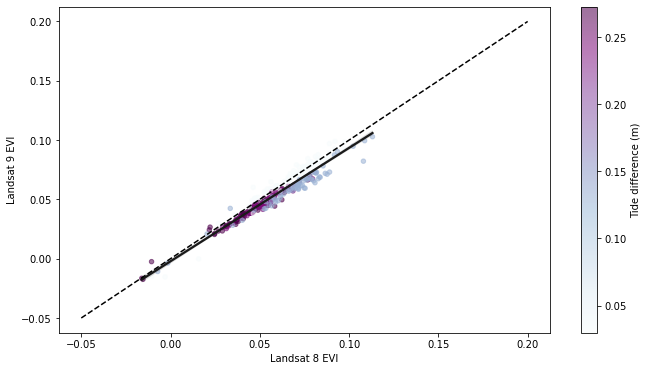

In [15]:
calibr_89 = pd.concat(calibr3)

# calibr_89 = calibr_89[calibr_89['ndwi'].between(-2, 2) & calibr_89['ndwi_1'].between(-2, 2)] #getting rid of the outliers
# calibr_89 = calibr_89[calibr_89['tidedifference'].between(-0.04, 0.04)]

fig, ax = plt.subplots()
fig.set_size_inches(11, 6)

points = plt.scatter(data = calibr_89, x = 'evi', y='evi_1',
                     c="tidedifference", s=20, cmap="BuPu", alpha=0.55)
plt.colorbar(points, label = 'Tide difference (m)')
sns.regplot(x='evi', y="evi_1", data=calibr_89, scatter=False, color=".1").set(xlabel='Landsat 8 EVI', ylabel='Landsat 9 EVI')

# g.set_axis_labels("L8 ndwi", "L9 ndwi")
# plt.plot([-0.1, 0.4], [-0.1, 0.4], 'k--')

# display(calibr_89)
print(len(calibr_89))
print(len(calibr_89['tidedifference'].unique()))

plt.plot([-0.05, 0.2], [-0.05, 0.2], 'k--')

# plt.savefig('flux_evi_89.png', bbox_inches='tight', dpi = 300)

In [16]:
#Cross cal regression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score

calibr_89 = pd.concat(calibr3)
calibr_89 = calibr_89[calibr_89['tidedifference'].between(-0.04, 0.04)] #Keep it consistent

#L8 = m*L9 + c

#evi
mod = sm.OLS(calibr_89.evi_1, calibr_89.evi)
res = mod.fit()

print(res.summary()) 

# lm = LinearRegression().fit(np.array(calibr_list.evi_1).reshape((-1, 1)), np.array(calibr_list.evi).reshape((-1, 1)))

print('evi: ')

x = calibr_89[['evi_1']] #L9
y = calibr_89['evi'] #L8
lm = LinearRegression().fit(x,y)

print(lm.coef_)
print(lm.intercept_)
print(lm.score)
print(len(x))

print(lm.score(x,y))

#ndwi

print('ndwi: ')

x = calibr_89[['ndwi_1']] #L9
y = calibr_89['ndwi'] #L8
lm = LinearRegression().fit(x,y)

print(lm.coef_)
print(lm.intercept_)
print(lm.score)

print(lm.score(x,y))
print(len(x))

                                 OLS Regression Results                                
Dep. Variable:                  evi_1   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          1.871e+04
Date:                Tue, 22 Aug 2023   Prob (F-statistic):                    9.54e-87
Time:                        09:24:08   Log-Likelihood:                          285.72
No. Observations:                  71   AIC:                                     -569.4
Df Residuals:                      70   BIC:                                     -567.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [17]:
df1.shape

df78 = df1.iloc[328:581,:]

df78

,Unnamed: 0,Image_x,Sensor_x,LS_x,Date_x,Date_A,Image_y,Sensor_y,LS_y,Date_y,Date_B,Tide_A,Tide_B,Tide_diff,Tidestatus_A,Tidestatus_B
332,4,LANDSAT/LE07/C02/T1_L2/LE07_016038_20130709,Landsat 7/8,Landsat 7,2013-07-09,2013-07-09,LANDSAT/LC08/C02/T1_L2/LC08_017038_20130708,Landsat 8/7,Landsat 8,2013-07-08,2013-07-08,0.079333,-0.194667,0.274000,Mid,Mid
333,5,LANDSAT/LE07/C02/T1_L2/LE07_016038_20130725,Landsat 7/8,Landsat 7,2013-07-25,2013-07-25,LANDSAT/LC08/C02/T1_L2/LC08_017038_20130724,Landsat 8/7,Landsat 8,2013-07-24,2013-07-24,1.149333,0.720333,0.429000,Flood,Mid
334,6,LANDSAT/LE07/C02/T1_L2/LE07_016038_20130810,Landsat 7/8,Landsat 7,2013-08-10,2013-08-10,LANDSAT/LC08/C02/T1_L2/LC08_017038_20130809,Landsat 8/7,Landsat 8,2013-08-09,2013-08-09,0.876333,0.626333,0.250000,Mid,Mid
335,7,LANDSAT/LE07/C02/T1_L2/LE07_016038_20130826,Landsat 7/8,Landsat 7,2013-08-26,2013-08-26,LANDSAT/LC08/C02/T1_L2/LC08_017038_20130825,Landsat 8/7,Landsat 8,2013-08-25,2013-08-25,1.215000,1.400333,0.185333,Flood,Flood
336,8,LANDSAT/LE07/C02/T1_L2/LE07_016038_20130911,Landsat 7/8,Landsat 7,2013-09-11,2013-09-11,LANDSAT/LC08/C02/T1_L2/LC08_017038_20130910,Landsat 8/7,Landsat 8,2013-09-10,2013-09-10,1.067667,1.168333,0.100667,Flood,Flood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,252,LANDSAT/LE07/C02/T1_L2/LE07_016038_20220507,Landsat 7/8,Landsat 7,2022-05-07,2022-05-07,LANDSAT/LC08/C02/T1_L2/LC08_016039_20220507,Landsat 8/7,Landsat 8,2022-05-07,2022-05-07,0.273667,0.273667,0.000000,Mid,Mid
581,253,LANDSAT/LE07/C02/T1_L2/LE07_016038_20220524,Landsat 7/8,Landsat 7,2022-05-24,2022-05-24,LANDSAT/LC08/C02/T1_L2/LC08_016038_20220523,Landsat 8/7,Landsat 8,2022-05-23,2022-05-23,-0.697000,-0.231333,0.465667,Mid,Mid
582,254,LANDSAT/LE07/C02/T1_L2/LE07_016038_20220726,Landsat 7/8,Landsat 7,2022-07-26,2022-07-26,LANDSAT/LC08/C02/T1_L2/LC08_016039_20220726,Landsat 8/7,Landsat 8,2022-07-26,2022-07-26,-0.904000,-0.904000,0.000000,Mid,Mid
583,255,LANDSAT/LE07/C02/T1_L2/LE07_017038_20220903,Landsat 7/8,Landsat 7,2022-09-03,2022-09-03,LANDSAT/LC08/C02/T1_L2/LC08_017038_20220903,Landsat 8/7,Landsat 8,2022-09-03,2022-09-03,0.752667,0.752667,0.000000,Mid,Mid


In [18]:
pd.set_option('display.max_columns', None)
print(calibr_89.head())

   percent  ST_ATRAN_1  ST_EMIS_1    nirv_1      nirv  tidedifference  \
0       90        8166       9692  0.071093  0.074513        0.029667   
1       90        8166       9729  0.070879  0.067885        0.029667   
2       90        8166       9729  0.063360  0.060077        0.029667   
3       90        8166       9729  0.058670  0.059265        0.029667   
4       90        8166       9749  0.056571  0.059282        0.029667   

       vari  ST_QA    ST_B10_1  ST_DRAD  QA_RADSAT  ST_EMIS     SR_B2  \
0 -0.027858    265  297.936803      359          0     9692  0.045575   
1 -0.020200    263  297.721468      359          0     9727  0.047775   
2 -0.008090    261  297.731722      359          0     9727  0.038150   
3  0.011536    260  297.745394      359          0     9727  0.032430   
4  0.045270    260  297.622346      359          0     9737  0.030752   

    SR_B4_1     SR_B3     SR_B4   SR_B6_1     SR_B5     SR_B6     SR_B7  \
0  0.073790  0.058775  0.060837  0.194213  0.16

In [19]:
'''
New equations (11/28/22), with 0.04 m max difference:


Landsat 5 - Landsat 7:

           EVI: 
                  L7EVI = 0.991*L5EVI - 0.0014 

           NDWI:                 
                  L7NDWI = 0.972*L5NDWI - 0.008


Landsat 7 - Landsat 8:

           EVI:
                  L7EVI = 0.771*L8EVI + 0.011

           NDWI:  

                  L7NDWI = 0.841*L8NDWI - 0.019

Landsat 8 - Landsat 9:

           EVI:
                  L8EVI = 0.974*L9EVI - 0.0005

           NDWI:  
                  L8NDWI = 0.945*L9NDWI - 0.055

'''

'\nNew equations (11/28/22), with 0.04 m max difference:\n\n\nLandsat 5 - Landsat 7:\n\n\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002EVI: \n\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002L7EVI = 0.991*L5EVI - 0.0014 \n\n\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002NDWI:\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\n\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002L7NDWI = 0.972*L5NDWI - 0.008\n\n\nLandsat 7 - Landsat 8:\n\n\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002EVI:\n\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002L7EVI = 0.771*L8EVI + 0.011\n\n\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002NDWI:\u2002\u2002\n\n\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u2002\u

In [20]:
#Added 12/01/22 - L7/9 comparison
#load 7/9 df
df2 = pd.read_csv('C:/Users/arj26323/Documents/Data/flats/79comp.csv')
df2['Date_A'] = pd.to_datetime(df2['Date_A'], format = '%Y-%m-%d')
df2['Date_B'] = pd.to_datetime(df2['Date_B'], format = '%Y-%m-%d')

#Tides
tides = pd.read_csv('C:/Users/arj26323/Documents/Data/flats/water_level_filtered_1999_2022.csv')
tides['Date'] = pd.to_datetime(tides['Date'], format = '%m/%d/%Y')

tides['Verified_m'] = tides['Verified_m'].str.replace("\U00002013", "-").str.replace(r'^-$', '0', regex=True).astype(float)

# display(tides['Date'])

dictide = tides.groupby(['Date'], as_index = False).aggregate({'Verified_m': np.mean}).set_index('Date').to_dict()['Verified_m'] 

df2['Tide_A'] = df2['Date_A'].map(dictide).astype(float)
df2['Tide_B'] = df2['Date_B'].map(dictide).astype(float)

df2 = df2[df2['Tide_A'].notna() & df2['Tide_B'].notna()]
df2['Tide_diff'] = abs(df2['Tide_B'] - df2['Tide_A']) ##Changed 1/12/23

conditions_A = [ df2['Tide_A'] >= 0.9, (df2['Tide_A'] < 0.9) & (df2['Tide_A']> -1.1), df2['Tide_A'] <= -1.1 ]
conditions_B = [ df2['Tide_B'] >= 0.9, (df2['Tide_B'] < 0.9) & (df2['Tide_B']> -1.1), df2['Tide_B'] <= -1.1 ]
choices = [ "Flood", 'Mid', 'Ebb' ]

df2['Tidestatus_A'] = np.select(conditions_A, choices, default=np.nan)
df2['Tidestatus_B'] = np.select(conditions_B, choices, default=np.nan)

df2

,Unnamed: 0,Image_x,Sensor_x,LS_x,Date_A,Image_y,Sensor_y,LS_y,Date_B,Tide_A,Tide_B,Tide_diff,Tidestatus_A,Tidestatus_B
0,0,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990711,Landsat 5/7,Landsat 5,1999-07-11,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990710,Landsat 7/5,Landsat 7,1999-07-10,-1.453000,-1.697333,0.244333,Ebb,Ebb
1,1,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990727,Landsat 5/7,Landsat 5,1999-07-27,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990726,Landsat 7/5,Landsat 7,1999-07-26,-0.645000,-0.911667,0.266667,Mid,Mid
2,2,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990812,Landsat 5/7,Landsat 5,1999-08-12,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990811,Landsat 7/5,Landsat 7,1999-08-11,0.426667,-0.031667,0.458333,Mid,Mid
3,3,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990828,Landsat 5/7,Landsat 5,1999-08-28,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990827,Landsat 7/5,Landsat 7,1999-08-27,0.575667,0.017000,0.558667,Mid,Mid
4,4,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990913,Landsat 5/7,Landsat 5,1999-09-13,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990912,Landsat 7/5,Landsat 7,1999-09-12,1.164667,1.143667,0.021000,Flood,Flood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,13,LANDSAT/LE07/C02/T1_L2/LE07_017038_20220404,Landsat 7/9,Landsat 7,2022-04-04,LANDSAT/LC09/C02/T1_L2/LC09_017038_20220404,Landsat 9/7,Landsat 9,2022-04-04,0.881333,0.881333,0.000000,Mid,Mid
599,14,LANDSAT/LE07/C02/T1_L2/LE07_016038_20220507,Landsat 7/9,Landsat 7,2022-05-07,LANDSAT/LC09/C02/T1_L2/LC09_017038_20220506,Landsat 9/7,Landsat 9,2022-05-06,0.273667,0.583667,0.310000,Mid,Mid
600,15,LANDSAT/LE07/C02/T1_L2/LE07_016038_20220709,Landsat 7/9,Landsat 7,2022-07-09,LANDSAT/LC09/C02/T1_L2/LC09_017038_20220709,Landsat 9/7,Landsat 9,2022-07-09,-0.945000,-0.945000,0.000000,Mid,Mid
601,16,LANDSAT/LE07/C02/T1_L2/LE07_016038_20220726,Landsat 7/9,Landsat 7,2022-07-26,LANDSAT/LC09/C02/T1_L2/LC09_017038_20220725,Landsat 9/7,Landsat 9,2022-07-25,-0.904000,-1.033667,0.129667,Mid,Mid


In [21]:
dfxx = df2[df2['Sensor_x'] == 'Landsat 7/9']
dfxx

,Unnamed: 0,Image_x,Sensor_x,LS_x,Date_A,Image_y,Sensor_y,LS_y,Date_B,Tide_A,Tide_B,Tide_diff,Tidestatus_A,Tidestatus_B
585,0,LANDSAT/LE07/C02/T1_L2/LE07_016038_20211206,Landsat 7/9,Landsat 7,2021-12-06,LANDSAT/LC09/C02/T1_L2/LC09_016039_20211206,Landsat 9/7,Landsat 9,2021-12-06,1.261333,1.261333,0.000000,Flood,Flood
586,1,LANDSAT/LE07/C02/T1_L2/LE07_017038_20211213,Landsat 7/9,Landsat 7,2021-12-13,LANDSAT/LC09/C02/T1_L2/LC09_017038_20211213,Landsat 9/7,Landsat 9,2021-12-13,-0.570667,-0.570667,0.000000,Mid,Mid
587,2,LANDSAT/LE07/C02/T1_L2/LE07_016038_20211222,Landsat 7/9,Landsat 7,2021-12-22,LANDSAT/LC09/C02/T1_L2/LC09_016038_20211222,Landsat 9/7,Landsat 9,2021-12-22,1.207000,1.207000,0.000000,Flood,Flood
588,3,LANDSAT/LE07/C02/T1_L2/LE07_017038_20211229,Landsat 7/9,Landsat 7,2021-12-29,LANDSAT/LC09/C02/T1_L2/LC09_017038_20211229,Landsat 9/7,Landsat 9,2021-12-29,-0.881333,-0.881333,0.000000,Mid,Mid
589,4,LANDSAT/LE07/C02/T1_L2/LE07_016038_20220107,Landsat 7/9,Landsat 7,2022-01-07,LANDSAT/LC09/C02/T1_L2/LC09_016039_20220107,Landsat 9/7,Landsat 9,2022-01-07,1.086667,1.086667,0.000000,Flood,Flood
590,5,LANDSAT/LE07/C02/T1_L2/LE07_017038_20220114,Landsat 7/9,Landsat 7,2022-01-14,LANDSAT/LC09/C02/T1_L2/LC09_017038_20220114,Landsat 9/7,Landsat 9,2022-01-14,-0.624333,-0.624333,0.000000,Mid,Mid
591,6,LANDSAT/LE07/C02/T1_L2/LE07_016038_20220123,Landsat 7/9,Landsat 7,2022-01-23,LANDSAT/LC09/C02/T1_L2/LC09_016039_20220123,Landsat 9/7,Landsat 9,2022-01-23,1.091333,1.091333,0.000000,Flood,Flood
592,7,LANDSAT/LE07/C02/T1_L2/LE07_017038_20220130,Landsat 7/9,Landsat 7,2022-01-30,LANDSAT/LC09/C02/T1_L2/LC09_017038_20220130,Landsat 9/7,Landsat 9,2022-01-30,-0.520000,-0.520000,0.000000,Mid,Mid
593,8,LANDSAT/LE07/C02/T1_L2/LE07_017038_20220215,Landsat 7/9,Landsat 7,2022-02-15,LANDSAT/LC09/C02/T1_L2/LC09_017038_20220215,Landsat 9/7,Landsat 9,2022-02-15,-0.249333,-0.249333,0.000000,Mid,Mid
594,9,LANDSAT/LE07/C02/T1_L2/LE07_016038_20220224,Landsat 7/9,Landsat 7,2022-02-24,LANDSAT/LC09/C02/T1_L2/LC09_016039_20220224,Landsat 9/7,Landsat 9,2022-02-24,-0.220333,-0.220333,0.000000,Mid,Mid


In [22]:
ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

l7_param = {'min': 0, 
             'max': 20000, 
             'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 
             'gamma': 1.5}

vis_param = {'min': 0, 
             'max': 20000, 
             'bands': ['SR_B5', 'SR_B4', 'SR_B3'], 
             'gamma': 1.5}

Map.addLayer(ee.Image('LANDSAT/LE07/C02/T1_L2/LE07_017038_20211213'), l7_param, 'L7')
Map.addLayer(ee.Image('LANDSAT/LC09/C02/T1_L2/LC09_017038_20211213'), vis_param, 'L9')

# Map.addLayer(dissolve_ga)

Map

Map(center=[31.539096, -81.422318], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

In [23]:
df79 = df2.iloc[581:,:] #Again, this range changes when NaN tide rows are filtered out

def addTide(img):
    tidediff = img.getNumber('tidediff')
    new_value = ee.Image(tidediff).rename('tidedifference')
    return img.addBands(new_value)

calibr4 = []
for i in range(585, len(df2)): #Again, this range changes when NaN tide rows are filtered out
    x = ee.Image(addFLATSL7(addvariL5(addeviL5(addnirvL5(addphenoL5(addndwiL5(maskL5sr(ee.Image(df79.loc[i, 'Image_x'])))))))))
    y = ee.Image(addFLATSL9(addvari(addevi(addnirv(addpheno(addndwi(maskL5sr(ee.Image(df79.loc[i, 'Image_y'])))))))))
    combined_image = addTide(x.addBands(y).set({'tidediff':df79.loc[i, 'Tide_diff']}))
    try:
        region = flux_ga
        sample79x = geemap.ee_to_pandas(combined_image.sampleRegions(collection = region, scale = 30))
        calibr4.append(sample79x) 
    except Exception:
        try:
            region = flux_ga
            sample79x = geemap.ee_to_pandas(combined_image.sampleRegions(collection = region, scale = 30))
            calibr4.append(sample79x)
        except Exception:
            continue

calibr_79 = pd.concat(calibr4)

29
1


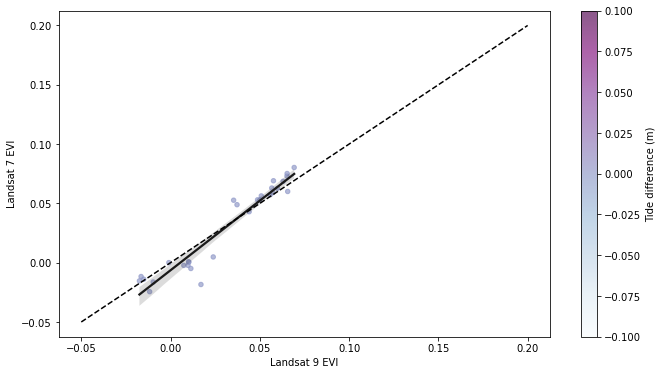

In [24]:
import seaborn as sns

calibr_79 = pd.concat(calibr4)
calibr_79['tidedifference'] = abs(calibr_79['tidedifference'])


# calibr_89 = calibr_89[calibr_89['ndwi'].between(-2, 2) & calibr_89['ndwi_1'].between(-2, 2)] #getting rid of the outliers
calibr_79 = calibr_79[calibr_79['tidedifference'].between(-0.04, 0.04)]

fig, ax = plt.subplots()
fig.set_size_inches(11, 6)

points = plt.scatter(data = calibr_79, x = 'evi_1', y='evi',
                     c="tidedifference", s=20, cmap="BuPu", alpha=0.65)
plt.colorbar(points, label = 'Tide difference (m)')
sns.regplot(x='evi_1', y="evi", data=calibr_79, scatter=False, color=".1").set(xlabel='Landsat 9 EVI', ylabel='Landsat 7 EVI')

# g.set_axis_labels("L8 ndwi", "L9 ndwi")
# plt.plot([-0.1, 0.4], [-0.1, 0.4], 'k--')

# display(calibr_89)
print(len(calibr_79))
print(len(calibr_79['tidedifference'].unique()))

plt.plot([-0.05, 0.2], [-0.05, 0.2], 'k--')

# plt.savefig('79.png', bbox_inches='tight', dpi = 300)

In [25]:
#Cross cal regression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score

calibr_79 = pd.concat(calibr4)
calibr_79 = calibr_79[calibr_79['tidedifference'].between(-0.04, 0.04)] #Keep it consistent

#L8 = m*L9 + c

#evi
mod = sm.OLS(calibr_79.evi_1, calibr_79.evi)
res = mod.fit()

print(res.summary()) 

# lm = LinearRegression().fit(np.array(calibr_list.evi_1).reshape((-1, 1)), np.array(calibr_list.evi).reshape((-1, 1)))

print('evi: ')

x = calibr_79[['evi_1']] #L9
y = calibr_79['evi'] #L7
lm = LinearRegression().fit(x,y)

print(lm.coef_)
print(lm.intercept_)
print(lm.score)
print(len(x))

print(lm.score(x,y))

#ndwi

print('ndwi: ')

x = calibr_79[['ndwi_1']] #L9
y = calibr_79['ndwi'] #L7
lm = LinearRegression().fit(x,y)

print(lm.coef_)
print(lm.intercept_)
print(lm.score)

print(lm.score(x,y))
print(len(x))

                                 OLS Regression Results                                
Dep. Variable:                  evi_1   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.945
Method:                 Least Squares   F-statistic:                              496.6
Date:                Tue, 22 Aug 2023   Prob (F-statistic):                    2.34e-19
Time:                        09:24:23   Log-Likelihood:                          92.896
No. Observations:                  29   AIC:                                     -183.8
Df Residuals:                      28   BIC:                                     -182.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [26]:
#Export data for easier use:
calibr_list = pd.concat(calibr)
calibr_78 = pd.concat(calibr2)
calibr_78 = calibr_78[calibr_78['tidedifference'] != 0]
calibr_79 = pd.concat(calibr4)
calibr_79['tidedifference'] = abs(calibr_79['tidedifference'])

#Export CSV file
out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'clipped_97.csv')
# calibr_79.to_csv(out_csv, index = False)

In [25]:
#Fin